In [7]:
import sys
import os
import matplotlib.pyplot as plt
import numpy as np

sys.path.append(os.path.abspath(os.path.join(os.path.dirname('Utils'), '..')))
from Utils.data_utils import load_preprocessed_data_from_folder

# Load the data from the CSV file into a pandas DataFrame
data = load_preprocessed_data_from_folder()

data

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,0.513755,0.571139,0.336096,0.543891,0.680385,0.669439,0.313402,0.699753,0.286091,0.0
1,0.265434,0.297400,0.300611,0.491839,0.610408,0.719411,0.497319,0.450999,0.576793,0.0
2,0.578509,0.641311,0.321619,0.698543,0.584737,0.414652,0.562017,0.532866,0.303637,0.0
3,0.594055,0.605536,0.356244,0.603314,0.647347,0.317880,0.622089,0.808065,0.601015,0.0
4,0.649445,0.484851,0.289922,0.484900,0.514545,0.379337,0.358555,0.253606,0.496327,0.0
...,...,...,...,...,...,...,...,...,...,...
3991,0.482531,0.524160,0.308924,0.442628,0.504566,0.407946,0.539767,0.485483,0.599330,1.0
3992,0.371926,0.442095,0.411976,0.546609,0.596498,0.292375,0.416480,0.524698,0.460797,1.0
3993,0.471553,0.290820,0.524454,0.747456,0.432994,0.558864,0.430764,0.599290,0.580482,1.0
3994,0.483064,0.484272,0.490260,0.783886,0.364165,0.535721,0.349975,0.552053,0.439660,1.0


In [8]:
from sklearn.model_selection import train_test_split

TEST_SIZE = 0.1
NUM_FOLDS = 5

train_df, test_df = train_test_split(data, test_size=TEST_SIZE)
train_df, test_df

(            ph  Hardness    Solids  Chloramines   Sulfate  Conductivity  \
 1032  0.621223  0.431716  0.450382     0.391305  0.691031      0.370847   
 3224  0.499251  0.546939  0.505051     0.553198  0.550480      0.588331   
 489   0.405126  0.498200  0.282512     0.388474  0.596699      0.398692   
 180   0.565504  0.836529  0.441192     0.694178  0.840234      0.310038   
 2411  0.537088  0.591068  0.272162     0.486627  0.612741      0.234388   
 ...        ...       ...       ...          ...       ...           ...   
 3837  0.551376  0.639245  0.366576     0.581664  0.542817      0.385600   
 3591  0.519715  0.646924  0.362851     0.565146  0.550334      0.303210   
 842   0.306640  0.599860  0.494421     0.648009  0.580866      0.352252   
 536   0.686204  0.556455  0.305169     0.560711  0.590153      0.331236   
 856   0.565585  0.641005  0.323304     0.677630  0.492553      0.420395   
 
       Organic_carbon  Trihalomethanes  Turbidity  Potability  
 1032        0.442478 

In [9]:
# bisect the data into features and target (potability)
train_x = train_df.drop('Potability', axis=1)
train_y = train_df['Potability']

test_x = test_df.drop('Potability', axis=1)
test_y = test_df['Potability']

In [10]:
# Naive random forest model

from sklearn.ensemble import RandomForestClassifier

random_forest = RandomForestClassifier()
random_forest.fit(train_x, train_y)

print(f'Random Forest test score: {random_forest.score(test_x, test_y):0.2%}')

Random Forest test score: 74.75%


In [11]:
from sklearn.model_selection import GridSearchCV

params = {
  'n_estimators': [100, 200],
  'max_depth': [None, 10, 20, 50],
  'min_samples_split': [2, 5, 10],
  'min_samples_leaf': [1, 2, 4],
  'criterion': ['gini', 'entropy']
}

grid_search = GridSearchCV(random_forest, params, scoring='f1', verbose=4, cv=NUM_FOLDS, n_jobs=-1)
grid_search.fit(train_x, train_y)

best_params = grid_search.best_params_

print(f'Random Forest test score: {grid_search.score(test_x, test_y):0.2%}')

Fitting 5 folds for each of 144 candidates, totalling 720 fits
Random Forest test score: 73.96%


In [12]:
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

print(f'Best model: {best_model}, best params: {best_params}')
print(f'Best model score: {best_model.score(test_x, test_y):0.2%}')

Best model: RandomForestClassifier(max_depth=50, n_estimators=200), best params: {'criterion': 'gini', 'max_depth': 50, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best model score: 75.00%


In [13]:
# Perform a manual search to graph the F1 score against the max_depth
from sklearn.metrics import f1_score

max_depths = range(1, 50 + 1)
scores = []


for max_depth in max_depths:
  # print(f'start: {max_depth}')
  params = dict(best_params, max_depth=max_depth)
  random_forest = RandomForestClassifier(**params)
  random_forest.fit(train_x, train_y)
  score = f1_score(test_y, random_forest.predict(test_x))
  scores.append(score)
  # print(f'end: {max_depth}')


# Modify the best params' max_depth accordingly
best_max_depth = max_depths[np.argmax(scores)]
best_params['max_depth'] = best_max_depth

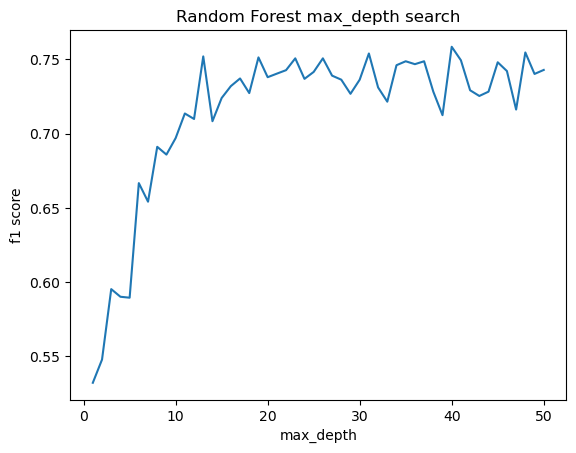

In [14]:
# Plot the search results

plt.plot(max_depths, scores)
plt.xlabel('max_depth')
plt.ylabel('f1 score')
plt.title('Random Forest max_depth search')

plt.show()

In [15]:
from sklearn.calibration import CalibratedClassifierCV

ideal_rf = RandomForestClassifier(**best_params)

calibrated_rf = CalibratedClassifierCV(ideal_rf, cv=NUM_FOLDS)
calibrated_rf.fit(train_x, train_y)

ideal_rf_prefit = RandomForestClassifier(**best_params)
ideal_rf_prefit.fit(train_x, train_y)

calibrated_rf_prefit = CalibratedClassifierCV(ideal_rf_prefit, cv='prefit')
calibrated_rf_prefit.fit(train_x, train_y)

print(f'Calibrated Random Forest (cv={NUM_FOLDS}) test score: {calibrated_rf.score(test_x, test_y):0.2%}')
print(f'Calibrated Random Forest (cv=prefit) test score: {calibrated_rf_prefit.score(test_x, test_y):0.2%}')

Calibrated Random Forest (cv=5) test score: 75.50%
Calibrated Random Forest (cv=prefit) test score: 75.00%


In [16]:
calibrated_rf.predict_proba(test_x)

array([[0.2566245 , 0.7433755 ],
       [0.17545735, 0.82454265],
       [0.74848268, 0.25151732],
       [0.4808168 , 0.5191832 ],
       [0.15830298, 0.84169702],
       [0.15930215, 0.84069785],
       [0.53290899, 0.46709101],
       [0.48954812, 0.51045188],
       [0.8091118 , 0.1908882 ],
       [0.8027052 , 0.1972948 ],
       [0.71461432, 0.28538568],
       [0.59434318, 0.40565682],
       [0.66255167, 0.33744833],
       [0.3307564 , 0.6692436 ],
       [0.6760027 , 0.3239973 ],
       [0.25541674, 0.74458326],
       [0.86774243, 0.13225757],
       [0.4209423 , 0.5790577 ],
       [0.46974359, 0.53025641],
       [0.78112221, 0.21887779],
       [0.47182424, 0.52817576],
       [0.28447727, 0.71552273],
       [0.3502912 , 0.6497088 ],
       [0.53774727, 0.46225273],
       [0.70067948, 0.29932052],
       [0.824307  , 0.175693  ],
       [0.38051923, 0.61948077],
       [0.69400176, 0.30599824],
       [0.56589765, 0.43410235],
       [0.40774764, 0.59225236],
       [0.

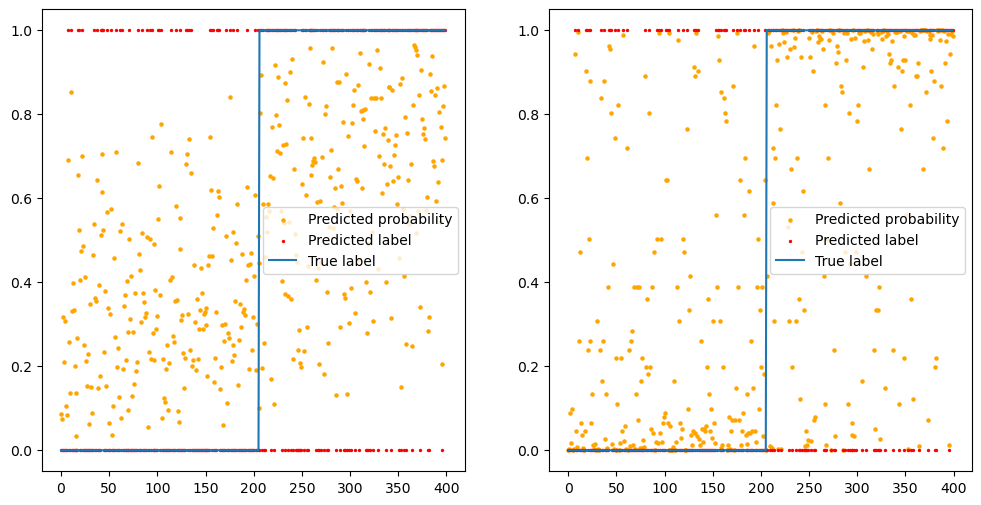

In [17]:
# Create a zipped array of sample index, predicted proability and true label
results = np.column_stack((
  calibrated_rf.predict_proba(test_x)[:, 1], 
  calibrated_rf.predict(test_x), 
  calibrated_rf_prefit.predict_proba(test_x)[:, 1],
  calibrated_rf_prefit.predict(test_x),
  test_y
  ))

# Sort by true label
results = results[results[:, -1].argsort()]

# Plot the predicted probabilities & true labels

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.scatter(range(len(results)), results[:, 0], label='Predicted probability', c='orange', s=5)
plt.scatter(range(len(results)), results[:, 1], label='Predicted label', c='red', s=2)
plt.plot(results[:, -1], label='True label')
plt.legend()

plt.subplot(1, 2, 2)
plt.scatter(range(len(results)), results[:, 2], label='Predicted probability', c='orange', s=5)
plt.scatter(range(len(results)), results[:, 3], label='Predicted label', c='red', s=2)
plt.plot(results[:, -1], label='True label')
plt.legend()

plt.show()




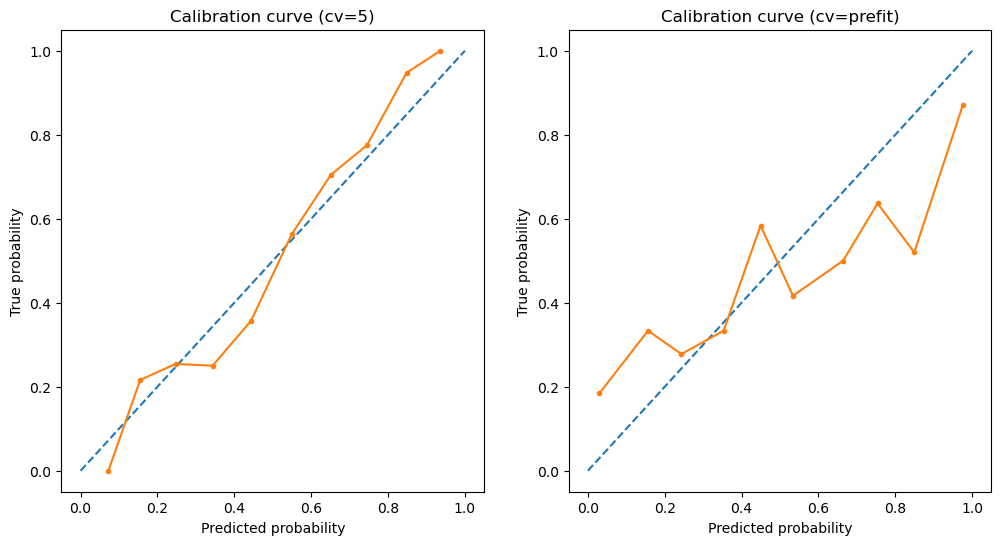

In [18]:
from sklearn.calibration import calibration_curve

# Plot the calibration curve for the two models

plt.figure(figsize=(12, 6))

prob_true, prob_pred = calibration_curve(test_y, calibrated_rf.predict_proba(test_x)[:, 1], n_bins=10)

plt.subplot(1, 2, 1)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(prob_pred, prob_true, marker='.')
plt.title('Calibration curve (cv=5)')
plt.xlabel('Predicted probability')
plt.ylabel('True probability')

prob_true, prob_pred = calibration_curve(test_y, calibrated_rf_prefit.predict_proba(test_x)[:, 1], n_bins=10)

plt.subplot(1, 2, 2)

plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(prob_pred, prob_true, marker='.')
plt.title('Calibration curve (cv=prefit)')
plt.xlabel('Predicted probability')
plt.ylabel('True probability')

plt.show()

In [14]:
# Try optimizing the hyperparameters with optuna
import optuna
from sklearn.model_selection import cross_val_score

N_TRIALS = 50

def objective(trial: optuna.Trial) -> float:
  params = {
    'n_estimators': trial.suggest_int('n_estimators', 100, 200),
    'max_depth': trial.suggest_int('max_depth', 1, 50),
    'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
    'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 4),
    'criterion': trial.suggest_categorical('criterion', ['gini', 'entropy'])
  }

  random_forest = RandomForestClassifier(**params)
  
  scores = cross_val_score(random_forest, train_x, train_y, scoring='f1', cv=NUM_FOLDS)
  return scores.mean()

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=N_TRIALS)

[I 2024-04-19 22:11:24,732] A new study created in memory with name: no-name-c2dcc4df-8866-4090-9700-47399c733258
[I 2024-04-19 22:11:26,336] Trial 0 finished with value: 0.4565146024232464 and parameters: {'n_estimators': 126, 'max_depth': 2, 'min_samples_split': 8, 'min_samples_leaf': 1, 'criterion': 'entropy'}. Best is trial 0 with value: 0.4565146024232464.
[I 2024-04-19 22:11:31,310] Trial 1 finished with value: 0.7010171423582372 and parameters: {'n_estimators': 143, 'max_depth': 46, 'min_samples_split': 9, 'min_samples_leaf': 4, 'criterion': 'gini'}. Best is trial 1 with value: 0.7010171423582372.
[I 2024-04-19 22:11:36,297] Trial 2 finished with value: 0.6830345863631029 and parameters: {'n_estimators': 104, 'max_depth': 14, 'min_samples_split': 4, 'min_samples_leaf': 2, 'criterion': 'entropy'}. Best is trial 1 with value: 0.7010171423582372.
[I 2024-04-19 22:11:41,410] Trial 3 finished with value: 0.6894029384809015 and parameters: {'n_estimators': 107, 'max_depth': 15, 'min_s